In [11]:
import yaml
from joblib import load
import pandas as pd
from backend.utils.data_preprocessor import DataPreprocessor

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"
lookback_period: int = config['preprocess']['lookback_period']
trend_length: int = config['preprocess']['trend_length']
target_column: str = config['preprocess']['target']
testing_file_path: str = f"../data/twelvedata/feature time series ({interval})/NVDA_feature_time_series.csv"
testing_df: pd.DataFrame = pd.read_csv(testing_file_path)


In [12]:
testing_preprocessor = DataPreprocessor(testing_df, lookback_period, target_column, trend_length)

X_test: [[[float]]] = testing_preprocessor.feature_data_batched
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
y_test: [float] = testing_preprocessor.label_data


In [13]:
scaler = load('scaler.save')
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)


In [14]:
print("Testing Dataset shape:", testing_df.shape)
print("Testing Dataset as time series batches:",X_test.shape, y_test.shape)
# %run ../tests/trend_provider_validator.py

Testing Dataset shape: (4970, 231)
Testing Dataset as time series batches: (4960, 9, 231) (4960,)


In [15]:
from keras.models import load_model
from backend.utils.model_evaluator import ModelEvaluator

model_path: str = "../models/saved models/trained_StockTrendLSTM_model.keras"
model = load_model(model_path)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
y_pred_prob: [float] = model.predict(X_test_scaled).flatten()
y_pred: [int] = (y_pred_prob > 0.5).astype(int)

model_evaluator = ModelEvaluator(test_loss, y_test, y_pred)
metrics_df = model_evaluator.evaluation_metrics
metrics_df

155/155 [==============================] - 2s 5ms/step


,Metric,Score
0,Loss,0.439902
1,Accuracy,0.809879
2,Precision,0.850939
3,Recall,0.776677
4,F1Score,0.812114
5,ROC AUC,0.811926


In [16]:
target_data: pd.DataFrame = testing_preprocessor.target_data[lookback_period:]
feature_data: pd.DataFrame = testing_preprocessor.feature_data[lookback_period:]
label_data: pd.DataFrame = testing_preprocessor.label_data

profits: pd.Series = target_data['close'].shift(-trend_length) - target_data['close']
profitable_trade: pd.Series = (profits > 0).astype(int)
last_close: pd.Series = target_data['close'].shift(8)
next_low: pd.Series = target_data['low'].shift(-1)
next_high: pd.Series = target_data['high'].shift(-1)
next_close: pd.Series = target_data['close'].shift(-1)

results: pd.DataFrame = target_data.assign(prediction=y_pred,
                                           probability=y_pred_prob,
                                           profit=profits,
                                           profitable=profitable_trade,
                                           next_low=next_low,
                                           next_high=next_high,
                                           next_close=next_close,
                                           last_close=last_close)

results: pd.DataFrame = results[['open', 'high', 'low', 'close','last_close', 'next_high', 'next_low', 'next_close', 'sma', 'profitable', 'label', 'prediction', 'probability']]
results.head(50)


,open,high,low,close,last_close,next_high,next_low,next_close,sma,profitable,label,prediction,probability
datetime,,,,,,,,,,,,,
2021-03-16 13:30:00,534.05,534.31,526.26,526.98,NaN,531.83,524.67,530.78,529.13,1,1,0,0.341046
2021-03-16 14:30:00,526.78,531.83,524.67,530.78,NaN,533.57,530.83,531.39,530.33,1,1,0,0.487155
2021-03-16 15:30:00,531.05,533.57,530.83,531.39,NaN,529.88,519.59,526.62,531.32,0,0,1,0.593279
2021-03-17 09:30:00,521.74,529.88,519.59,526.62,NaN,527.64,522.54,525.49,531.58,0,0,0,0.179677
2021-03-17 10:30:00,526.07,527.64,522.54,525.49,NaN,525.93,520.50,525.22,531.28,0,0,0,0.094251
2021-03-17 11:30:00,525.27,525.93,520.50,525.22,NaN,525.25,521.03,525.16,529.93,0,0,0,0.078613
2021-03-17 12:30:00,525.00,525.25,521.03,525.16,NaN,535.16,522.00,528.95,528.56,1,1,0,0.061581
2021-03-17 13:30:00,525.14,535.16,522.00,528.95,NaN,538.12,527.92,535.20,528.31,1,1,0,0.213464
2021-03-17 14:30:00,529.00,538.12,527.92,535.20,526.98,536.97,530.79,533.98,528.42,0,1,1,0.519848


In [17]:
high_over_close: bool = (results['next_low'] < results['last_close'])
probability: bool = (results['probability'] > 0.92)

sma_opportunities: pd.DataFrame = results[probability]
print(sma_opportunities['label'].value_counts())
print(sma_opportunities['profitable'].value_counts(normalize=True))

sma_opportunities

label
1    153
0      2
Name: count, dtype: int64
profitable
1    0.574194
0    0.425806
Name: proportion, dtype: float64


,open,high,low,close,last_close,next_high,next_low,next_close,sma,profitable,label,prediction,probability
datetime,,,,,,,,,,,,,
2021-08-04 11:30:00,201.04,202.10,200.01,202.06,194.51,202.71,201.41,202.44,198.26,1,1,1,0.920745
2021-08-04 12:30:00,202.07,202.71,201.41,202.44,196.77,202.74,201.45,202.46,199.14,1,1,1,0.925070
2021-08-04 13:30:00,202.45,202.74,201.45,202.46,196.98,202.78,201.63,202.23,199.77,0,1,1,0.925985
2021-08-04 15:30:00,202.29,203.18,202.04,202.74,197.95,207.32,203.42,204.72,200.92,1,1,1,0.926400
2021-08-05 10:30:00,204.74,206.16,203.94,205.33,199.27,206.32,204.81,205.88,202.47,1,1,1,0.928065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 11:30:00,287.56,289.51,287.20,288.88,284.22,289.90,288.56,289.45,286.00,1,1,1,0.923644
2023-05-08 12:30:00,288.89,289.90,288.56,289.45,283.97,290.58,288.17,290.05,286.58,1,1,1,0.924983
2023-05-08 14:30:00,290.05,292.18,290.00,291.59,286.25,292.20,291.29,291.54,288.03,0,1,1,0.923761


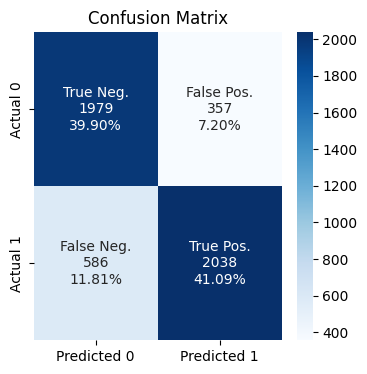

In [18]:
from backend.utils.visualizing_service import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred)

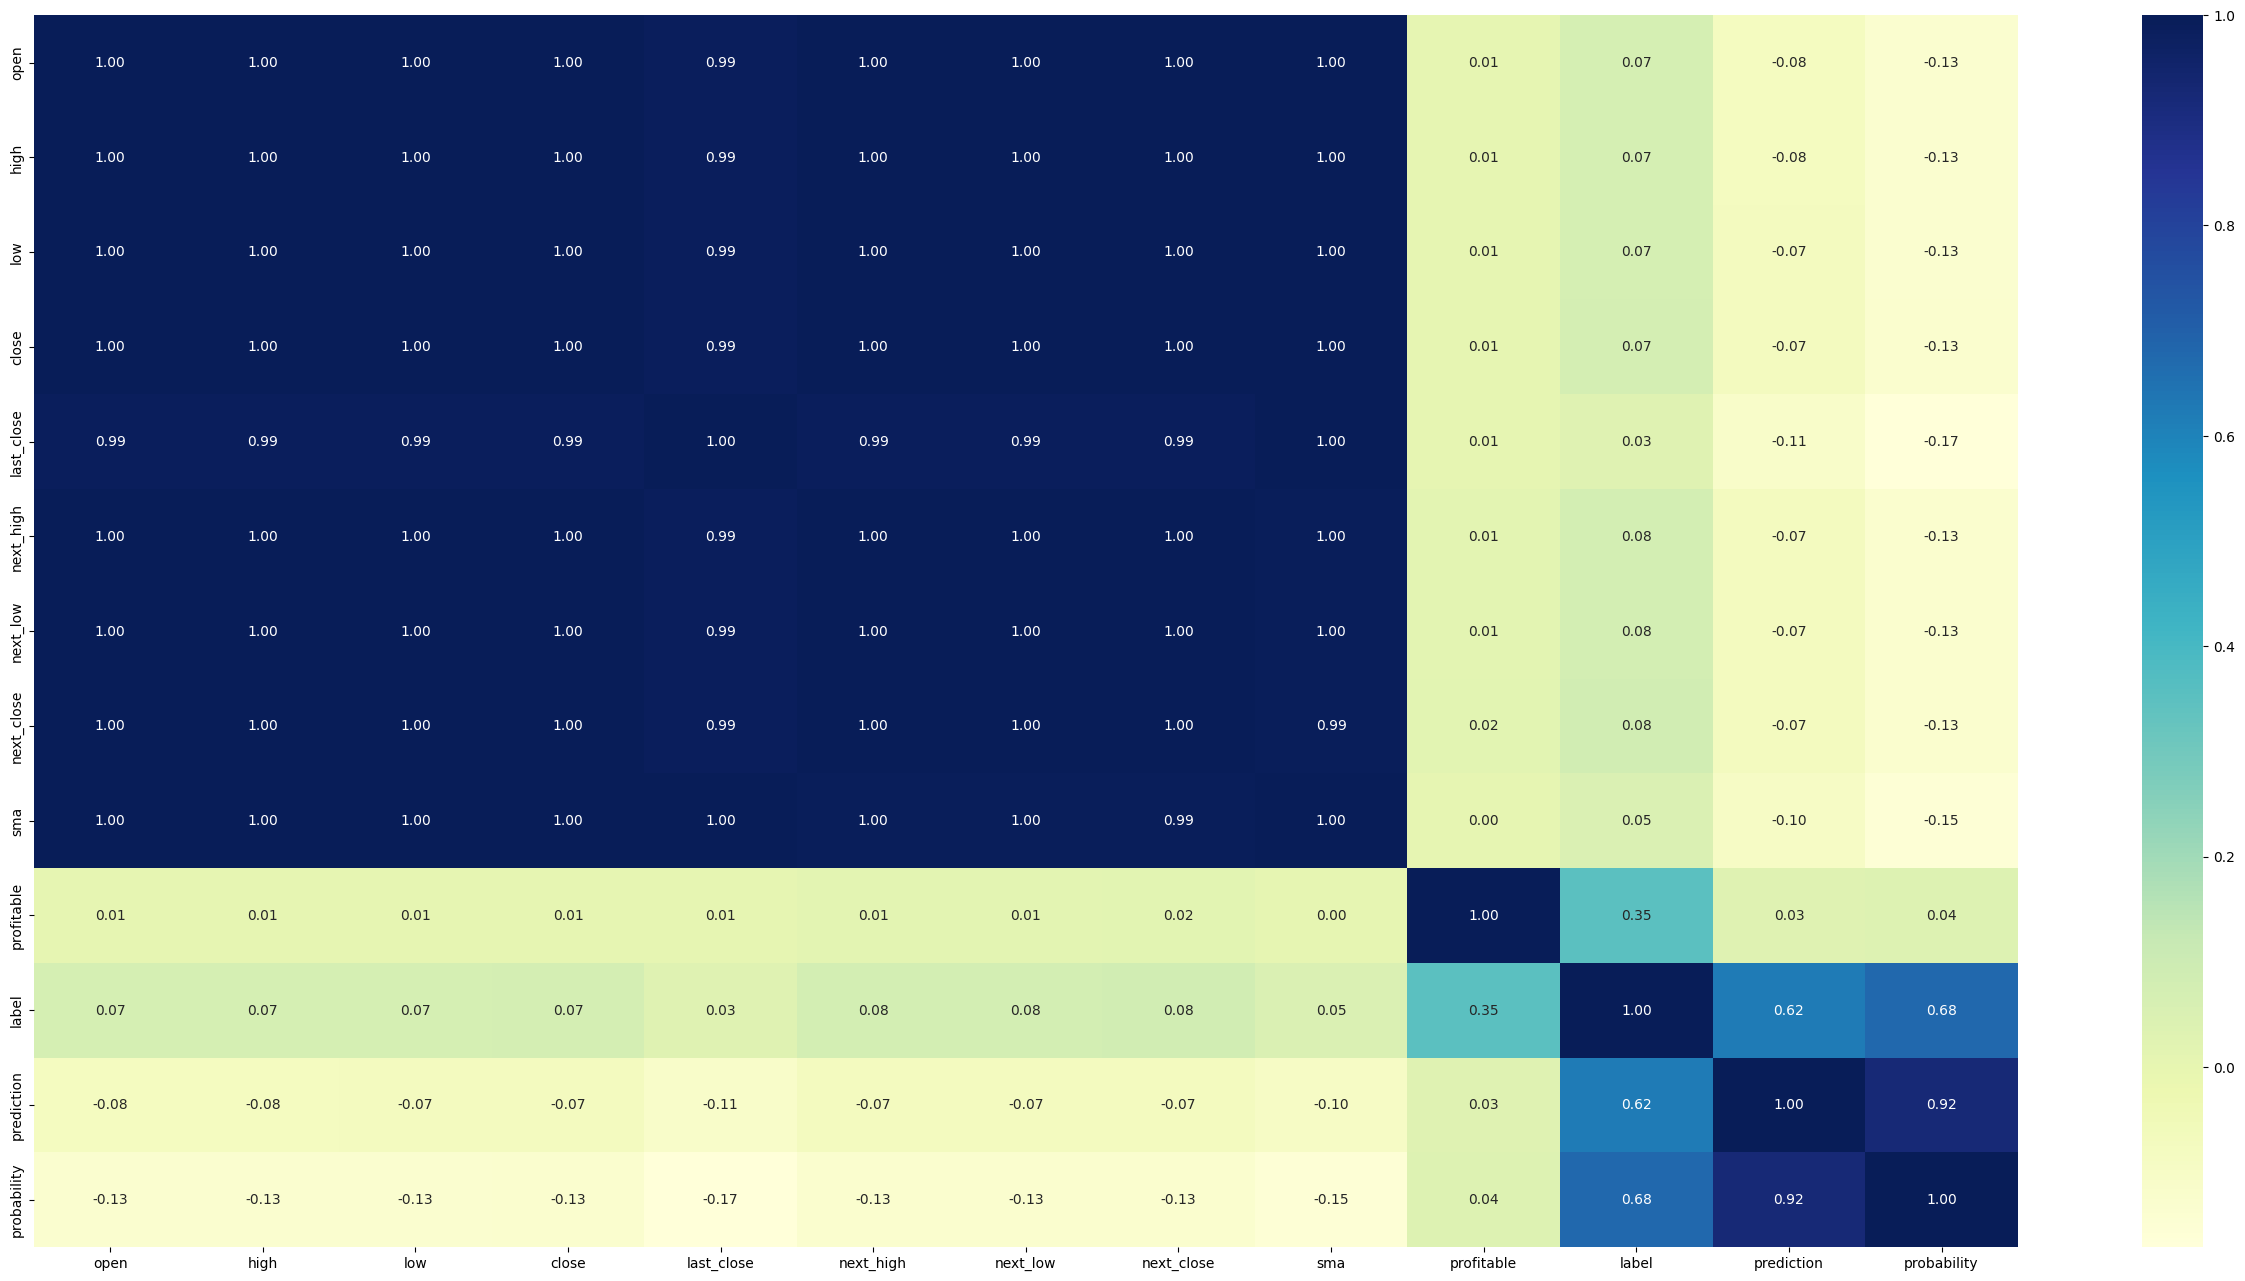

In [19]:
from backend.utils.visualizing_service import plot_correlation_heatmap
plot_correlation_heatmap(results)
